# Impact of redundant features on SHAP values

In [1]:
import os
import pickle
from math import pi

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns 
import shap
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import sympy
# from sympy import cos, sin, symbols

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model


from synthetic_data.synthetic_data import make_tabular_data

### Set up random seed & plotting function for use later

In [41]:
def no_tick_labels(ax):
    ax.axes.get_xaxis().set_ticks([])  # suppress x tick labels
    ax.axes.get_yaxis().set_ticks([])
    return

def my_tricontour(ax, x1, x2, y, z, labels=None, title=None, levels=None, scatter=True, bar=True, ticks=True):
    tri2 = ax.tricontourf(x1, x2, z, levels=levels, cmap='afmhot_r')
    if scatter:
        scatter = ax.scatter(x1, x2, c=y, label=y, marker=".")
        #leg1 = ax.legend(*scatter.legend_elements(), loc="lower right", title="class")

    ax.set_title(title)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    
    ax.set_xlim([-1, 1]) 
    ax.set_ylim([-1, 1]) 
    
    if bar:
        cbar2 = fig.colorbar(tri2, ax=ax, fraction=0.046, pad=0.08,format='%.2f' )
        #cbar2.formatter.set_powerlimits((0, 0)) 
        cbar2.update_ticks()
    if not ticks:
        no_tick_labels(ax)
    # ax.set_aspect("equal", "box")
    ax.set_aspect("equal")
    return

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # or any {'0', '1', '2'}                                                   
# Set the seed for hash based operations in python
os.environ["PYTHONHASHSEED"] = "0" 
np.random.seed(111)
tf.random.set_seed(111)
seed = 1234

plt.rc('text', usetex=True)

### Baseline data

In [3]:
# define symbols
# x1, x2 = symbols("x1 x2")

# define expression
expr = "cos(x1 ** 2 * pi / 180.0) - sin(x2 * pi / 180.0) + x1 * x2"

# define mapping from symbols to column of X - clunky TODO - make it better
col_map = {"x1": 0, "x2": 1}

# define correlations via covariance matrix
cov = np.array([[1.0, 0.0], [0.0, 1.0]])

n_samples = 1000
p_thresh = 0.5   # probability threshold to divide class 0 from class 1
# every other parameter is going to use the default - check docstring for completion

In [4]:
X, y_reg, y_prob, y_label = make_tabular_data(n_samples=n_samples, cov=cov, col_map=col_map, expr=expr, p_thresh=p_thresh, seed=seed)


### With redundant features

In [5]:
n_redundant=2
n_nuisance = 2

In [6]:
X_red, y_red_reg, y_red_prob, y_red_label = make_tabular_data(n_samples=n_samples, n_redundant=n_redundant, n_nuisance=n_nuisance, cov=cov, col_map=col_map, expr=expr, p_thresh=p_thresh, seed=seed)

### Let's see what we got!
#### Baseline features

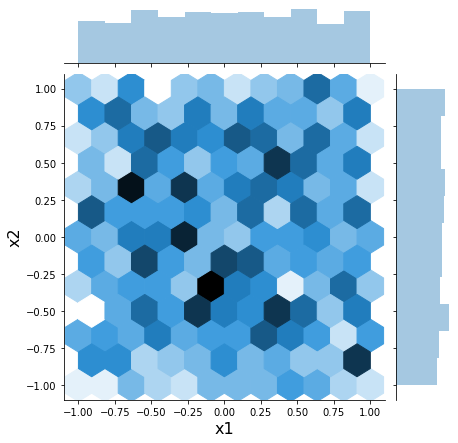

In [7]:
h = sns.jointplot(X[:, 0], X[:, 1], kind="hex", stat_func=None)
h.set_axis_labels("x1", "x2", fontsize=16)

#### Redundant features

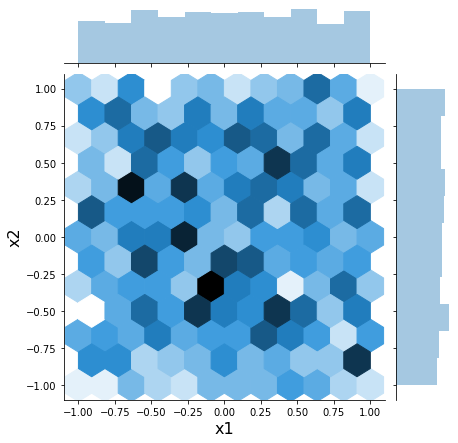

In [8]:
h = sns.jointplot(X_red[:, 0], X_red[:, 1], kind="hex", stat_func=None)
h.set_axis_labels("x1", "x2", fontsize=16)

## Let's check the impact on y_reg

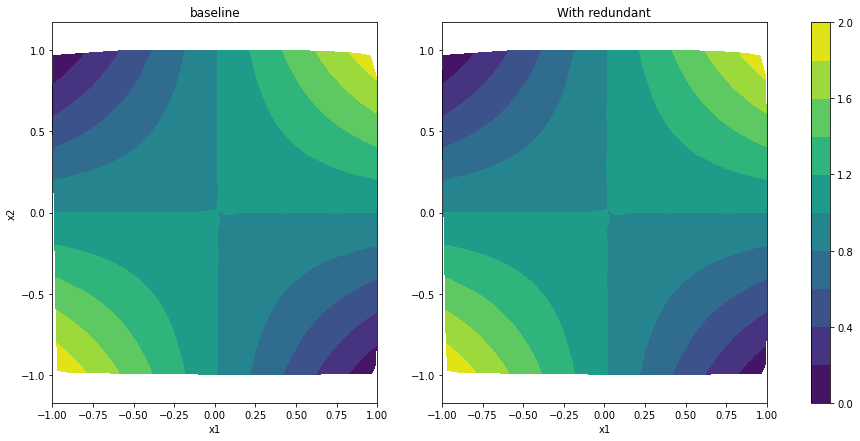

In [9]:
levels = np.arange(0, 2.2, 0.2)
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(16, 7))
tri1 = ax[0].tricontourf(X[:, 0], X[:, 1], y_reg, levels=levels)
#scatter = ax[0].scatter(X[:, 0], X[:, 1], c=y_label, label=y_label, marker=".")
#leg1 = ax[0].legend(*scatter.legend_elements(), loc="lower right", title="class")
#cbar1 = fig.colorbar(tri1, ax=ax)
ax[0].set_title("baseline")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis('equal')
#cbar1.formatter.set_powerlimits((0, 0))
#cbar1.update_ticks()

tri1 = ax[1].tricontourf(X_red[:, 0], X_red[:, 1], y_red_reg, levels=levels)
#scatter = ax[1].scatter(X_red[:, 0], X_red[:, 1], c=y_red_label, label=y_red_label, marker=".")
#leg1 = ax[1].legend(*scatter.legend_elements(), loc="lower right", title="class")
cbar1 = fig.colorbar(tri1, ax=ax)
ax[1].set_title("With redundant")
ax[1].set_xlabel("x1")
ax[1].axis('equal')
#ax[1].set_ylabel("x2")
#cbar1.formatter.set_powerlimits((0, 0))
cbar1.update_ticks()


No changes to see here - since the informative features remain fixed (thanks random seed!).

## Similar plots but with y_prob = sigmoid(y_reg)

This is the last step in the creation of our binary class labels.

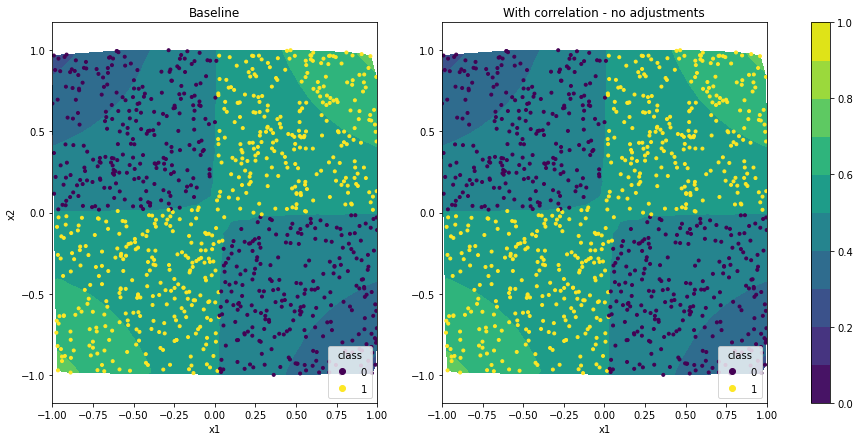

In [10]:
levels = np.arange(0, 1.1, 0.1)
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(16, 7))
tri1 = ax[0].tricontourf(X[:, 0], X[:, 1], y_prob, levels=levels)
scatter = ax[0].scatter(X[:, 0], X[:, 1], c=y_label, label=y_label, marker=".")
leg1 = ax[0].legend(*scatter.legend_elements(), loc="lower right", title="class")
#cbar1 = fig.colorbar(tri1, ax=ax)
ax[0].set_title("Baseline")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
ax[0].axis('equal')
#cbar1.formatter.set_powerlimits((0, 0))
#cbar1.update_ticks()

tri1 = ax[1].tricontourf(X_red[:, 0], X_red[:, 1], y_red_prob, levels=levels)
scatter = ax[1].scatter(X_red[:, 0], X_red[:, 1], c=y_red_label, label=y_red_label, marker=".")
leg1 = ax[1].legend(*scatter.legend_elements(), loc="lower right", title="class")
cbar1 = fig.colorbar(tri1, ax=ax)
ax[1].set_title("With redundant features")
ax[1].set_xlabel("x1")
ax[1].axis('equal')
#ax[1].set_ylabel("x2")
#cbar1.formatter.set_powerlimits((0, 0))
cbar1.update_ticks()


In [11]:
np.mean(y_reg)

0.99386746

In [12]:
np.mean(y_red_reg)

0.99386746

Those means are the same (right?  - take a look and make sure - ), random seeds are working and results should be repeatable.

### Train test split in preparation for building models

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y_label, test_size=0.3, random_state=42)
x_red_train, x_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red_label, test_size=0.3, random_state=42)

## Define models

In [21]:
act1 = "relu"
init1 = "he_normal"
act2 = "sigmoid"
init2 = "glorot_normal"


input = Input(shape=(2,))
#x = Dense(16, activation=act1, kernel_initializer=init1)(input)
x = Dense(12, activation=act1, kernel_initializer=init1)(input)
x = Dense(8, activation=act1, kernel_initializer=init1)(x)
x = Dense(6, activation=act1, kernel_initializer=init1)(x)
x = Dense(2, activation=act1, kernel_initializer=init1)(x)
output = Dense(1, activation=act2, kernel_initializer=init2)(x)

base_model = Model(input, output)
base_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# save the compiled model so we can reuse the same network for the correlated data
#base_model.save('base_arch.h5') # saves compiled state

input = Input(shape=(x_red_train.shape[1],))
#x = Dense(16, activation=act1, kernel_initializer=init1)(input)
xr = Dense(12, activation=act1, kernel_initializer=init1)(input)
xr = Dense(8, activation=act1, kernel_initializer=init1)(xr)
xr = Dense(6, activation=act1, kernel_initializer=init1)(xr)
xr = Dense(2, activation=act1, kernel_initializer=init1)(xr)
output = Dense(1, activation=act2, kernel_initializer=init2)(xr)

red_model = Model(input, output)
red_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

### Fit models

In [22]:
base_model.fit(x_train, y_train, epochs=100, batch_size=100, shuffle=True, validation_data=(x_test, y_test),verbose=0)


In [23]:
red_model.fit(x_red_train, y_red_train, epochs=100, batch_size=100, shuffle=True, validation_data=(x_red_test, y_red_test),verbose=0)

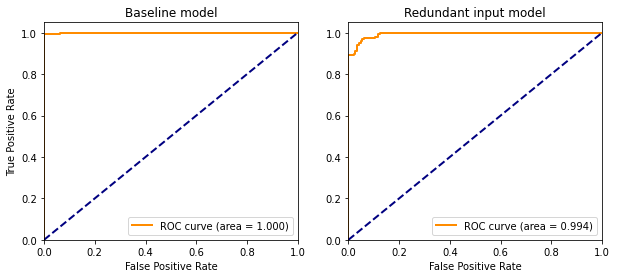

In [24]:
# calculate ROC curve and AUC...
y_test_pred = base_model.predict(x_test)
y_red_test_pred = red_model.predict(x_red_test)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
fpr_cor, tpr_cor, _ = roc_curve(y_red_test, y_red_test_pred)
roc_auc = auc(fpr, tpr)
roc_auc_cor = auc(fpr_cor, tpr_cor)
#print(f"Model AUC = {roc_auc:5.3f}")

lw = 2
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].plot(fpr, tpr, color="darkorange", lw=lw, label=f"ROC curve (area = {roc_auc:4.3f})")
ax[0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[0].set_xlim([0.0, 1.0])                                                                                                 
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Baseline model")
ax[0].legend(loc="lower right")

ax[1].plot(fpr_cor, tpr_cor, color="darkorange", lw=lw, label=f"ROC curve (area = {roc_auc_cor:4.3f})")
ax[1].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[1].set_xlim([0.0, 1.0])                                                                                                 
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel("False Positive Rate")
#ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("Redundant input model")
ax[1].legend(loc="lower right")

## SHAP values

In [25]:
exp = shap.DeepExplainer(base_model, x_train)
local_attr_list = exp.shap_values(x_train)
local_attr = np.array(local_attr_list).squeeze()

exp = shap.DeepExplainer(red_model, x_red_train)
local_attr_list = exp.shap_values(x_red_train)
local_attr_red = np.array(local_attr_list).squeeze()

x_red_train.shape

(700, 6)

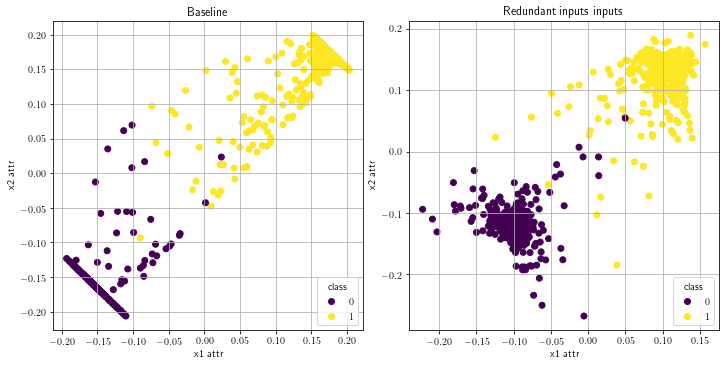

In [29]:
# scatter plot of attributions
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

scatter1 = ax[0].scatter(local_attr[:, 0], local_attr[:, 1], c=y_train, label=y_train)
ax[0].legend(*scatter1.legend_elements(), loc="lower right", title="class")
ax[0].set_xlabel("x1 attr")
ax[0].set_ylabel("x2 attr")
ax[0].set_title('Baseline')
ax[0].grid()

ax[1].scatter(local_attr_red[:, 0], local_attr_red[:, 1], c=y_train, label=y_train)
ax[1].legend(*scatter1.legend_elements(), loc="lower right", title="class")
ax[1].set_xlabel("x1 attr")
ax[1].set_ylabel("x2 attr")
ax[1].set_title('Redundant inputs inputs')
ax[1].grid()

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


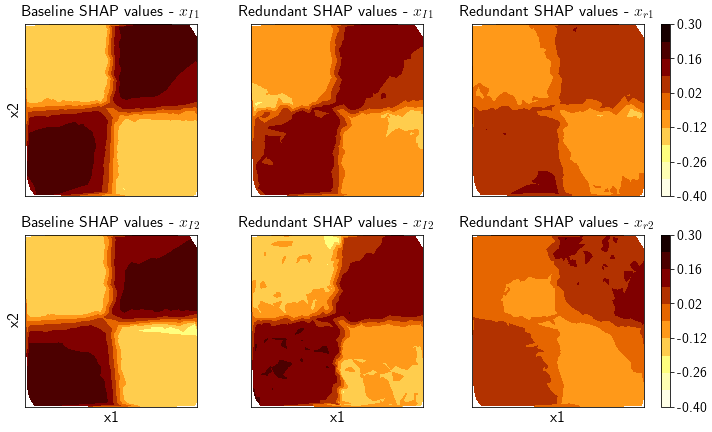

In [44]:
# contour map of attributions
levels = np.linspace(-0.4,0.3, 11)
SMALL = 14
MEDIUM = 16
LARGE = 18

plt.rc("font", size=SMALL)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL)  # legend fontsize
plt.rc("figure", titlesize=LARGE)  # fontsize of the figure title



fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
x1 = x_train[:, 0]
x2 = x_train[:, 1]
z = local_attr[:, 0]
my_tricontour(ax[0,0], x1, x2, y_train, z, labels=["", "x2"], title="Baseline SHAP values - $x_{I1}$", levels=levels, scatter=False, bar=False, ticks=False)

z = local_attr[:, 1]
my_tricontour(ax[1,0], x1, x2, y_train, z, labels=["x1", "x2"], title="Baseline SHAP values - $x_{I2}$", levels=levels, scatter=False,bar=False, ticks=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# correlated inputs
x1 = x_red_train[:, 0]
x2 = x_red_train[:, 1]
z = local_attr_red[:, 0]
my_tricontour(ax[0,1], x1, x2, y_red_train, z, labels=["", ""], title="Redundant SHAP values - $x_{I1}$ ", levels=levels, scatter=False,bar=False, ticks=False)

z = local_attr_red[:, 1]
my_tricontour(ax[1,1], x1, x2, y_red_train, z, labels=["x1", ""], title="Redundant SHAP values - $x_{I2}$", levels=levels,scatter=False, bar=False, ticks=False)
# correlated inputs
x1 = x_red_train[:, 0]
x2 = x_red_train[:, 1]
z = local_attr_red[:, 2]
my_tricontour(ax[0,2], x1, x2, y_red_train, z, labels=["", ""], title="Redundant SHAP values - $x_{r1}$ ", levels=levels,scatter=False, bar=True, ticks=False)

z = local_attr_red[:, 3]
my_tricontour(ax[1,2], x1, x2, y_red_train, z, labels=["x1", ""], title="Redundant SHAP values - $x_{r2}$", levels=levels, scatter=False,bar=True, ticks=False)
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=1.0)
plt.savefig('redundant_shap_values_summary.png')

In [38]:
z.min()

-0.11699545391927665

In [39]:
z.max()

0.16591192779956154